## 📊 NB03 - Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lets_plot import *

LetsPlot.setup_html()

ModuleNotFoundError: No module named 'seaborn'

In [139]:
import pandas as pd
import sqlite3

# Define the database path
db = "../data/chess.db"  

# Connect to the database
conn = sqlite3.connect(db)

# Define the table name (assuming it was named 'fide_data' when imported)
table = "fide"  

# Read data from the database into a Pandas DataFrame
df = pd.read_sql(f"SELECT * FROM {table}", conn)

# Close the database connection
conn.close()

# Sort the DataFrame by 'date'
df = df.sort_values(by="date")

# Display the first few rows to check
print(df.head())

      fide_id                name federation  world_rank_active_players  \
202   1503014      Magnus Carlsen         NO                          1   
1789  5000017   Viswanathan Anand         IN                         10   
605   2016192     Hikaru Nakamura         US                          3   
1411  4168119  Ian Nepomniachtchi         RU                          9   
1785  5000017   Viswanathan Anand         IN                         10   

          date  standard  rapid  blitz  
202   Apr 2001      2064    NaN    NaN  
1789  Apr 2001      2794    NaN    NaN  
605   Apr 2001      2428    NaN    NaN  
1411  Apr 2002      2280    NaN    NaN  
1785  Apr 2002      2752    NaN    NaN  


In [140]:
# Add a new column for differences between modes
df['std_blitz_diff'] = df['standard'] - df['blitz']
df['std_rapid_diff'] = df['standard'] - df['rapid']
df['rapid_blitz_diff'] = df['rapid'] - df['blitz']

# Average differences by player
player_differences = df.groupby('name')[['std_blitz_diff', 'std_rapid_diff', 'rapid_blitz_diff']].mean()
print(player_differences)


                       std_blitz_diff  std_rapid_diff  rapid_blitz_diff
name                                                                   
Alireza Firouzja            -8.567376       96.460993       -105.028369
Erigaisi Arjun              85.979452      188.957627       -109.576271
Fabiano Caruana             51.065789       23.811594         26.608696
Gukesh D                   265.314516      523.391304       -310.395161
Hikaru Nakamura           -103.789474      -39.789116        -67.190476
Ian Nepomniachtchi         -46.756579      -31.592105        -15.164474
Magnus Carlsen             -36.703947       -7.434211        -29.269737
Nodirbek Abdusattorov       65.089041      144.993464        -86.239726
Viswanathan Anand           -2.609929        4.065359         -8.170213
Yi Wei                      43.638158       28.152174         25.224638


In [141]:
# Calculate the mean of differences for each player
player_differences = df.groupby('name')[['std_blitz_diff', 'std_rapid_diff', 'rapid_blitz_diff']].mean().reset_index()

# Reshape the data to long format for plotting
player_differences_long = player_differences.melt(id_vars=['name'], 
                                                   value_vars=['std_blitz_diff', 'std_rapid_diff', 'rapid_blitz_diff'], 
                                                   var_name='comparison', value_name='average_difference')

# Rename the comparison values for better clarity
player_differences_long['comparison'] = player_differences_long['comparison'].replace({
    'std_blitz_diff': 'std-blitz difference',
    'std_rapid_diff': 'std-rapid difference',
    'rapid_blitz_diff': 'rapid-blitz difference'
})

# Build the plot
rating_diff_plot = (ggplot(player_differences_long) +
     geom_bar(aes(x='name', y='average_difference', fill='comparison', group='comparison'), 
              stat='identity', position='dodge', width=0.7, color='black', size=0.3) + 
     ggtitle('What is the average difference in performance \n between game modes for top 10 chess players?') +
     ylab('Average Difference in Ratings') + 
     theme(axis_text_x=element_text(angle=90, hjust=1, size=11),  
           plot_title=element_text(hjust=0.5),  
           legend_title=element_blank(),
           legend_text=element_text(size=11), 
           legend_position='bottom',
           axis_title_x=element_blank()) + 
     scale_fill_manual(values=['#6ab6e7', '#cd5c44', '#addf1d']))

# Display the plot
rating_diff_plot


The above plot visualizes the performance comparisons between each game mode, for all the top 10 chess players. In general, a positive score indicates better performance in the first game mode listed, and a negative score indicates better performance in the second (e.g., Alireza Firouzja's std-blitz difference is -8.57, indicating better performance in blitz; Erigaisi Arjun's score is 86 for the same condition, indicating stronger standard performance)

/var/folders/3w/kl11tgh95_70kfy5tyt37p8w0000gn/T/ipykernel_39859/326576213.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])  # Convert to datetime


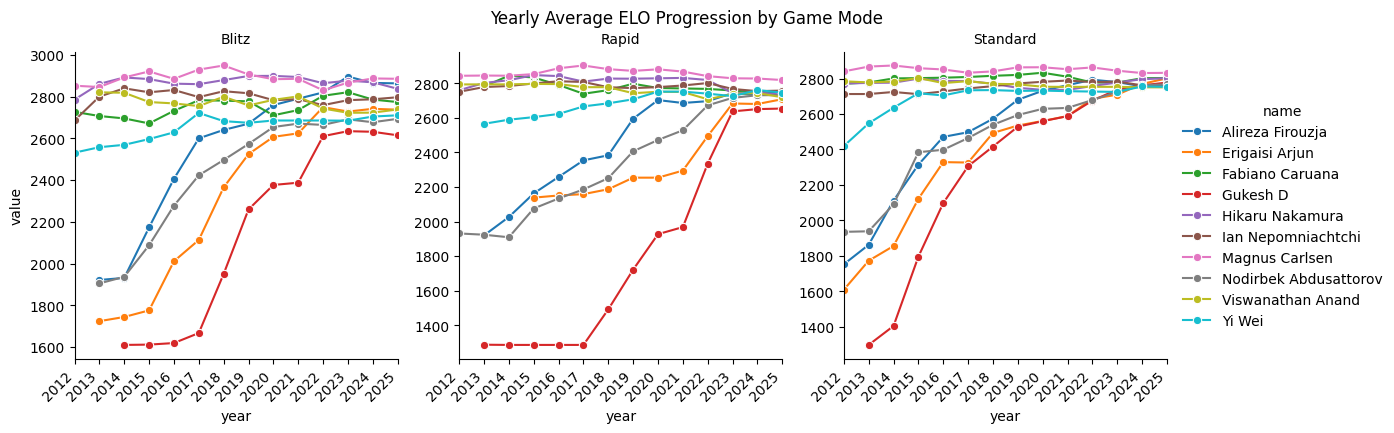

In [142]:
df['date'] = pd.to_datetime(df['date'])  # Convert to datetime
df['year'] = df['date'].dt.year  # Extract the year

# Melt the dataframe
melted_df = df.melt(id_vars=['name', 'date', 'year'], value_vars=['standard', 'rapid', 'blitz'])

# Calculate average ELO per year for each player and game mode
df_avg_yearly = (
    melted_df.groupby(['name', 'year', 'variable'], as_index=False)
             .agg({'value': 'mean'})
)

# Capitalize the game modes
df_avg_yearly['variable'] = df_avg_yearly['variable'].str.capitalize()

# Create the FacetGrid
g = sns.FacetGrid(df_avg_yearly, col='variable', hue='name', sharey=False, col_wrap=3, height=4)
g.map(sns.lineplot, 'year', 'value', marker='o').add_legend()

# Set x-axis limits and slant labels
for ax in g.axes.flat:
    ax.set_xlim(2012, df_avg_yearly['year'].max())  # Set xlim from 2010 to max year
    ax.set_xticks(range(2012, df_avg_yearly['year'].max() + 1))  # Set x-ticks as integer years
    ax.set_xticklabels(range(2012, df_avg_yearly['year'].max() + 1), rotation=45, ha="right")  # Slant the labels

# Set titles and display
g.set_titles("{col_name}")
g.fig.suptitle("Yearly Average ELO Progression by Game Mode", y=1.02)
plt.show()


### Draft

In [143]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], format='%Y-%b')
df = df.sort_values(['name', 'date'])  

In [144]:
df.groupby('name')[['standard', 'rapid', 'blitz']].describe()

standard                                            \
                         count         mean         std     min      25%   
name                                                                       
Alireza Firouzja         150.0  2510.126667  311.698406  1734.0  2366.00   
Erigaisi Arjun           157.0  2345.337580  368.231351  1528.0  2120.00   
Fabiano Caruana          200.0  2724.120000  183.171105  2026.0  2763.75   
Gukesh D                 139.0  2320.079137  453.202550  1253.0  2077.00   
Hikaru Nakamura          207.0  2732.487923   94.373605  2261.0  2736.00   
Ian Nepomniachtchi       202.0  2704.232673  111.627893  2243.0  2705.00   
Magnus Carlsen           203.0  2793.660099  156.529242  2064.0  2826.50   
Nodirbek Abdusattorov    157.0  2451.579618  277.047625  1907.0  2375.00   
Viswanathan Anand        207.0  2773.502415   18.472723  2748.0  2754.00   
Yi Wei                   172.0  2645.354651  159.126699  2138.0  2634.00   

                                               rapid               ...  \
                          50%     75%     max  count         mean  ...   
name                                                               ...   
Alireza Firouzja       2607.0  2759.0  2804.0  141.0  2461.375887  ...   
Erigaisi Arjun         2517.0  2629.0  2801.0  118.0  2342.491525  ...   
Fabiano Caruana        2792.0  2811.0  2844.0  138.0  2779.985507  ...   
Gukesh D               2528.0  2638.5  2794.0  138.0  1804.144928  ...   
Hikaru Nakamura        2767.0  2785.0  2816.0  147.0  2810.510204  ...   
Ian Nepomniachtchi     2734.0  2771.0  2795.0  152.0  2783.361842  ...   
Magnus Carlsen         2843.0  2862.0  2882.0  152.0  2859.907895  ...   
Nodirbek Abdusattorov  2546.0  2646.0  2783.0  153.0  2320.522876  ...   
Viswanathan Anand      2774.0  2786.0  2817.0  153.0  2764.849673  ...   
Yi Wei                 2725.0  2732.0  2763.0  138.0  2688.565217  ...   

                                        blitz                           \
                           75%     max  count         mean         std   
name                                                                     
Alireza Firouzja       2703.00  2756.0  141.0  2566.404255  324.035403   
Erigaisi Arjun         2450.00  2714.0  146.0  2315.143836  399.610189   
Fabiano Caruana        2810.75  2858.0  152.0  2750.217105   54.349606   
Gukesh D               2223.00  2656.0  124.0  2173.000000  415.488409   
Hikaru Nakamura        2837.00  2853.0  152.0  2874.684211   27.675370   
Ian Nepomniachtchi     2801.00  2821.0  152.0  2798.526316   38.968479   
Magnus Carlsen         2881.00  2919.0  152.0  2889.177632   40.641887   
Nodirbek Abdusattorov  2593.00  2742.0  146.0  2425.431507  287.994346   
Viswanathan Anand      2794.00  2822.0  141.0  2770.560284   34.635731   
Yi Wei                 2752.00  2782.0  152.0  2652.605263   59.078145   

                                                                 
                          min      25%     50%      75%     max  
name                                                             
Alireza Firouzja       1921.0  2415.00  2660.0  2796.00  2904.0  
Erigaisi Arjun         1723.0  1851.00  2464.0  2719.00  2774.0  
Fabiano Caruana        2665.0  2710.50  2745.0  2800.00  2847.0  
Gukesh D               1604.0  1619.00  2368.5  2602.25  2659.0  
Hikaru Nakamura        2778.0  2859.25  2879.0  2894.00  2934.0  
Ian Nepomniachtchi     2666.0  2782.00  2798.0  2821.00  2880.0  
Magnus Carlsen         2828.0  2856.00  2885.0  2915.00  2986.0  
Nodirbek Abdusattorov  1904.0  2148.00  2550.0  2663.50  2715.0  
Viswanathan Anand      2709.0  2739.00  2767.0  2791.00  2832.0  
Yi Wei                 2401.0  2606.00  2685.0  2686.00  2740.0  

[10 rows x 24 columns]

In [145]:
# Ensure 'date' is in datetime format
df['date'] = pd.to_datetime(df['date'], format='%b %Y', errors='coerce')

# Filter the data to include only dates from 2013 onward (these are the full ones)
df = df[df['date'] >= '2013-01-01']

# Drop rows with missing values in relevant columns
df = df.dropna(subset=['standard', 'rapid', 'blitz', 'date'])

# Aggregate ratings by date and mode
df_agg = df.melt(id_vars=['date'], value_vars=['standard', 'rapid', 'blitz'], 
                 var_name='mode', value_name='rating')

# Calculate the mean rating for each mode across all players for each date
df_agg_avg = df_agg.groupby(['date', 'mode']).agg({'rating': 'mean'}).reset_index()

# Build the plot
aggregate_plot = (ggplot(df_agg_avg) +
     geom_line(aes(x='date', y='rating', color='mode', group='mode')) +
     ggtitle('How do the average performance of top 10 chess players change, \n depending on game mode?') +
     xlab('Date') + 
     ylab('Average Rating (Elo)') +
     theme(axis_text_x=element_text(angle=45, hjust=1),
           plot_title=element_text(hjust=0.5)) +
     scale_x_datetime(labels=["%b %Y"])  
    )

# Display the plot
aggregate_plot


NOTE TO SELF: here, add a graph comparing the rapid trend line above w/ the chess.com one